In [54]:
# %reset
# Para visualización en notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 22
from IPython.display import Audio, Markdown, Image
import pylab
import seaborn as sns

# Números y Datos
import numpy as np
import pandas as pd

# Archivos
import urllib.request
import glob

# Análisis de sonido
import spotipy 

# Machine learning
# importar los paquetes para clustering
from sklearn.preprocessing import StandardScaler

# To work with categorical types
from pandas.api.types import CategoricalDtype

# Clustering (scipy)
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster

# Clustering (sklearn)
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics.pairwise import euclidean_distances

from funciones import plot_silhouette
from funciones import plot_silhouettes_and_sses
from funciones import get_silhouette_avg
from funciones import get_sse
from funciones import vanDongen

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import MDS, Isomap, SpectralEmbedding, TSNE

from umap import UMAP

Se cargan los datasets.

In [2]:
# Estandarizando de una manera o de la otra, los resultados son bastante distintos
scaler = MinMaxScaler(feature_range=(0,1))
#scaler = StandardScaler()

In [3]:
metadata_original = pd.read_csv('../data/metadata.csv', index_col='id')
audio_features_original = pd.read_csv('../data/audio_features.csv', index_col='id')
audio_analysis_original = pd.read_csv('../data/audio_analysis.csv', index_col='id')

In [4]:
audio_analysis_original.head()

,timbre_mean_0,timbre_mean_1,timbre_mean_2,timbre_mean_3,timbre_mean_4,timbre_mean_5,timbre_mean_6,timbre_mean_7,timbre_mean_8,timbre_mean_9,...,pitch_std_2,pitch_std_3,pitch_std_4,pitch_std_5,pitch_std_6,pitch_std_7,pitch_std_8,pitch_std_9,pitch_std_10,pitch_std_11
id,,,,,,,,,,,,,,,,,,,,,
2NChLGjZ93zqggig6DmoLL,39.573680,-53.160322,33.955933,-13.458602,10.908333,-34.851049,1.713744,0.357444,-9.248460,-3.464805,...,0.314326,0.182297,0.175415,0.315322,0.197047,0.190721,0.152499,0.315809,0.165763,0.112952
3TPucnH2T71lgcmhsTZVMT,37.806990,26.905931,45.066553,-1.566750,19.836837,-10.684136,-37.983923,-10.510028,-5.820575,-1.746866,...,0.293350,0.250039,0.339806,0.311496,0.260636,0.341519,0.176243,0.284082,0.300141,0.236217
5ruWnyGX0r6v8b2JisDHDo,50.307463,65.649677,-17.158870,-1.660690,30.536530,-47.617183,1.200309,1.357931,-2.241743,4.456728,...,0.361503,0.331288,0.333903,0.320905,0.290592,0.337753,0.306255,0.320579,0.347926,0.315364
4ZEVoBaSKdJfpeunWmyQfs,38.453838,-46.715751,-16.638915,-3.838850,34.693517,-27.530044,5.632033,2.938340,7.223357,-0.045737,...,0.211055,0.172432,0.307475,0.226574,0.209167,0.271316,0.221715,0.297126,0.209825,0.216391
66aVNocFLApjTfudNYVEiF,52.072411,98.597172,-16.693923,0.843767,42.616539,-42.602253,-3.609067,11.836476,2.011623,0.462091,...,0.277745,0.307850,0.362859,0.300253,0.295673,0.236315,0.301466,0.244227,0.257769,0.281606


Se seleccionan únicamente las variables numéricas

In [5]:
audio_features = audio_features_original[['acousticness','danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness','loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']]

Se estandarizan ambos datasets

In [6]:
audio_features_norm = pd.DataFrame(scaler.fit_transform(audio_features))
audio_analysis_norm = pd.DataFrame(scaler.fit_transform(audio_analysis_original))

In [7]:
audio_features_norm.dtypes

0     float64
1     float64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    float64
dtype: object

In [8]:
audio_features_norm.shape

(2206, 13)

In [9]:
audio_analysis_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0.631852,0.514083,0.632182,0.371474,0.330484,0.406210,0.491472,0.444832,0.511890,0.320476,...,0.675561,0.377418,0.353323,0.702285,0.401350,0.404643,0.303871,0.707795,0.333903,0.217312
1,0.594079,0.700458,0.663992,0.445142,0.390849,0.641027,0.110158,0.324041,0.558357,0.358914,...,0.625619,0.538103,0.737021,0.692536,0.550664,0.768081,0.361499,0.630782,0.658289,0.521457
2,0.861348,0.790645,0.485836,0.444560,0.463189,0.282168,0.486540,0.455952,0.606870,0.497714,...,0.787885,0.730829,0.723243,0.716511,0.621003,0.759003,0.677042,0.719374,0.773642,0.716743
3,0.607909,0.529085,0.487324,0.431066,0.491294,0.477344,0.529109,0.473518,0.735173,0.396975,...,0.429684,0.354018,0.661560,0.476147,0.429809,0.598885,0.471862,0.662444,0.440267,0.472538
4,0.899084,0.867339,0.487167,0.460074,0.544861,0.330895,0.440344,0.572420,0.664526,0.408337,...,0.588465,0.675232,0.790829,0.663888,0.632934,0.514529,0.665420,0.534038,0.556003,0.633450


# Experiencia 1: KMeans

## audio_features

Para audio_features, se determina la cantidad de clusters utilizando silhuette y SSE.

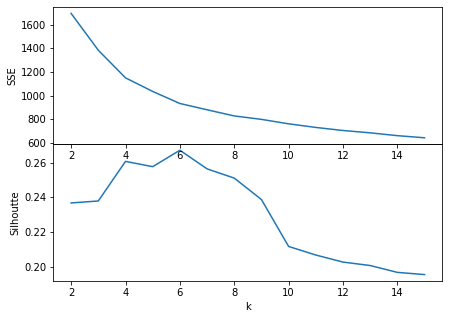

In [10]:
plot_silhouettes_and_sses(audio_features_norm, 15)

¿Cuál sería el k ideal? El quiebre de SSE lo tenemos más o menos en 5 o en 6. Con valores más altos de k el silhouette baja demasiado.

In [11]:
get_silhouette_avg(audio_features_norm, 5)

0.25766166657469736

In [12]:
get_silhouette_avg(audio_features_norm, 6)

0.2671537021257521

El silhouette promedio obtenido en 5 es mayor que en 6. Ya con 7 y 8 el silhouette parece bajar demasiado y no obtenemos mucha ganancia en el SSE.

In [13]:
get_sse(audio_features_norm, 5)

1035.7447075838425

In [14]:
get_sse(audio_features_norm, 6)

933.7499974161

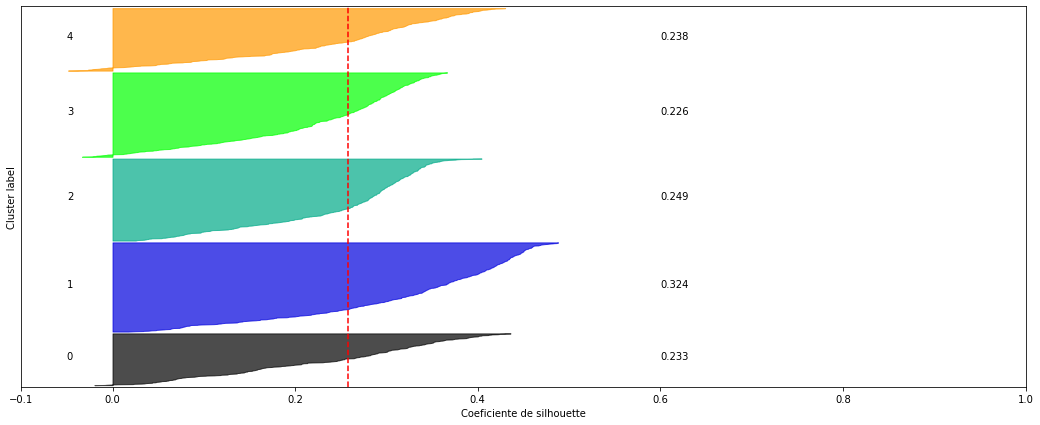

In [15]:
plot_silhouette(audio_features_norm, 5)

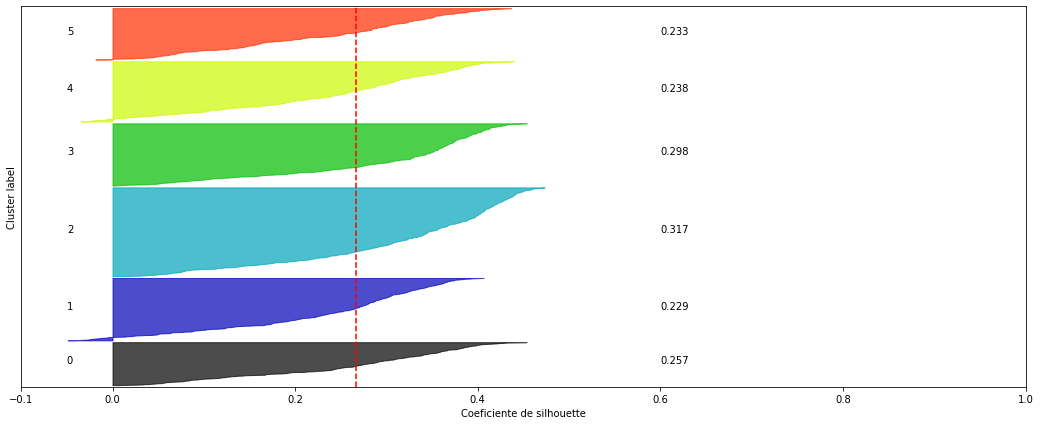

In [16]:
plot_silhouette(audio_features_norm, 6)

Conclusión: Estandarizado el dataset, da bastante mal. Para audio_features, los resultados sin estandarizar dan mucho mejor.

## audio_analysis

Para audio_analysis, se determina la cantidad de clusters utilizando silhuette y SSE.

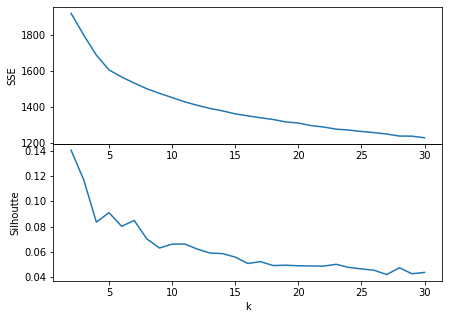

In [17]:
plot_silhouettes_and_sses(audio_analysis_norm, 30)

¿Qué valor de k podría ser mejor? Pareciera estar entre k = 3 y k = 10.

In [18]:
sils_sses = []
for k in range(3, 11):
    sils_sses.append([k, get_silhouette_avg(audio_analysis_norm, k), get_sse(audio_analysis_norm, k)])
pd.DataFrame(sils_sses, columns=['k', 'silhouette', 'sse'])

,k,silhouette,sse
0,3,0.116956,1798.685271
1,4,0.083628,1687.614378
2,5,0.091107,1606.202775
3,6,0.080344,1566.812911
4,7,0.084920,1533.190130
5,8,0.070323,1501.609414
6,9,0.063148,1476.175802
7,10,0.066223,1453.083273


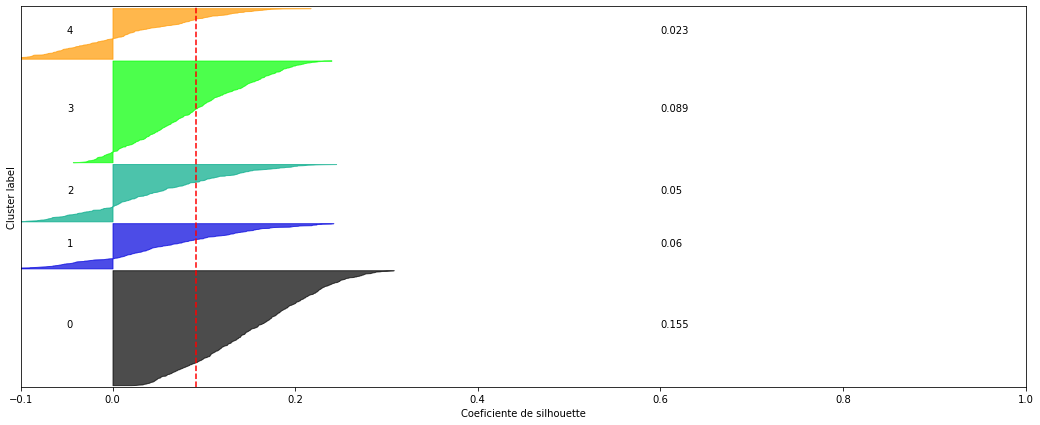

In [19]:
plot_silhouette(audio_analysis_norm, 5)

## audio_features y audio_analysis

Para ambos dataset mergeados, se determina la cantidad de clusters utilizando silhuette y SSE, estandarizando el merge previamente.

In [20]:
audio_tracks = pd.merge(audio_features, audio_analysis_original, how = 'inner', on = 'id')
audio_tracks = pd.DataFrame(scaler.fit_transform(audio_tracks))
audio_tracks.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.960843,0.548122,0.082639,0.107589,0.001237,0.000000,0.124419,0.585975,1.0,0.046954,...,0.802287,0.376643,0.777766,0.706363,0.427796,0.653960,0.540056,0.731551,0.460954,0.575116
1,0.956827,0.496479,0.080985,0.031669,0.000004,0.363636,0.082086,0.465891,1.0,0.067078,...,0.408663,0.608343,0.716047,0.463458,0.659931,0.517344,0.739438,0.671177,0.431654,0.866917
2,0.992972,0.395540,0.055235,0.149656,0.913481,0.454545,0.334022,0.524560,0.0,0.021574,...,0.417869,0.625047,0.498719,0.783958,0.493448,0.757215,0.774316,0.475171,0.792816,0.662595
3,0.174695,0.474178,0.240354,0.773642,0.706237,0.818182,0.695405,0.764218,0.0,0.224075,...,0.593346,0.514347,0.674562,0.570471,0.524046,0.656667,0.550310,0.708587,0.591251,0.653416
4,0.437748,0.463615,0.111798,0.501211,0.905433,0.909091,0.094476,0.701451,0.0,0.017223,...,0.526155,0.762025,0.668920,0.627626,0.586320,0.592038,0.531126,0.585538,0.607191,0.408642


In [21]:
audio_tracks.shape

(2205, 61)

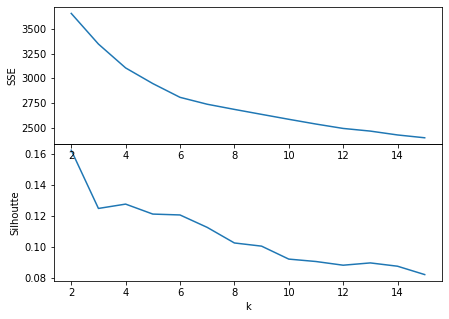

In [22]:
plot_silhouettes_and_sses(audio_tracks, 15)

Parece haber dado muy parecido a audio_features.

In [23]:
sils_sses = []
for k in range(3, 7):
    sils_sses.append([k, get_silhouette_avg(audio_tracks, k), get_sse(audio_tracks, k)])
pd.DataFrame(sils_sses, columns=['k', 'silhouette', 'sse'])

,k,silhouette,sse
0,3,0.125105,3345.869679
1,4,0.127913,3106.186474
2,5,0.121462,2948.924480
3,6,0.120893,2810.721734


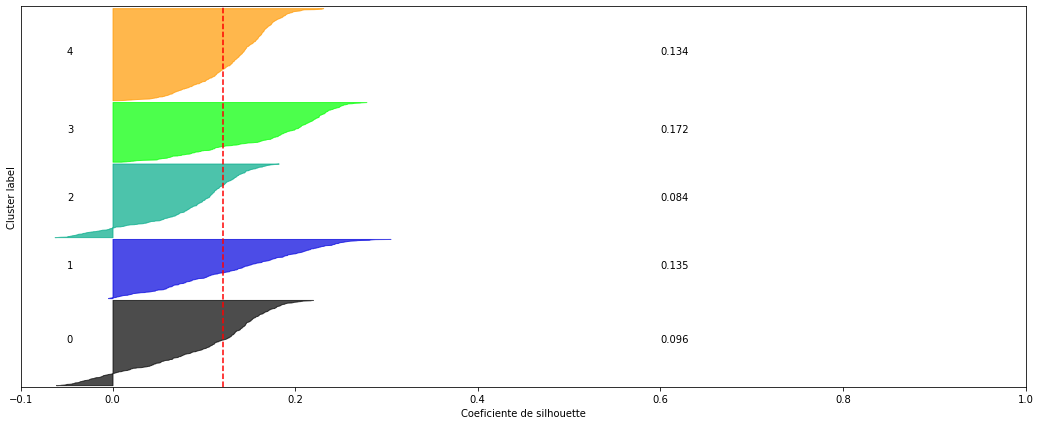

In [24]:
plot_silhouette(audio_tracks, 5)

De vuelta, audio_tracks da prácticamente lo mismo que audio_features. Parece que los summaries de audio_analysis no influyen mucho en los resultados de KMeans.

## b) Evaluar si los agrupamientos son similares para los distintos conjuntos de datos utilizando la matriz de confusión y los índices de Rand y van Dongen en los casos que correspondan

### Matrices de confusión

In [25]:
# Para que las comparaciones sean del mismo largo,
# se remueve de audio_feature el track que no se encuentra en audio_analysis
merged = audio_features.merge(audio_analysis_original, how = 'left', on = 'id')
id_to_remove = merged[merged.timbre_mean_0.isnull()].index[0]
audio_features_minus_one = audio_features.drop(id_to_remove, axis = 0)
audio_features_minus_one.shape

(2205, 13)

In [26]:
# Se ordenan los tres datasets para que los tracks estén en el mismo orden
audio_features_sorted = audio_features_minus_one.sort_index()
audio_analysis_sorted = audio_analysis_original.sort_index()
audio_tracks_sorted = audio_tracks.sort_index()

In [27]:
# Los vuelvo a estandarizar
audio_features_sorted = pd.DataFrame(scaler.fit_transform(audio_features_sorted))
audio_analysis_sorted = pd.DataFrame(scaler.fit_transform(audio_analysis_sorted))
audio_tracks_sorted = pd.DataFrame(scaler.fit_transform(audio_tracks_sorted))

In [28]:
# Vamos a comparar todos los KMeans con k = 5
km_audio_features = KMeans(n_clusters = 5, random_state = 0).fit(audio_features_sorted)
km_audio_analysis = KMeans(n_clusters = 5, random_state = 0).fit(audio_analysis_sorted)
km_audio_tracks = KMeans(n_clusters = 5, random_state = 0).fit(audio_tracks_sorted)

In [29]:
# Matriz de confusión: audio_features VS audio_analysis
tmp1 = pd.DataFrame({'audio_features': km_audio_features.labels_, 'audio_analysis': km_audio_analysis.labels_})
ct1 = pd.crosstab(tmp1['audio_features'], tmp1['audio_analysis'])
ct1

audio_analysis,0,1,2,3,4
audio_features,,,,,
0,33,26,21,35,193
1,123,119,97,28,121
2,7,10,13,273,70
3,172,139,120,25,76
4,7,9,23,321,144


In [30]:
# Matriz de confusión: audio_features VS audio_tracks
tmp2 = pd.DataFrame({'audio_features': km_audio_features.labels_, 'audio_tracks': km_audio_tracks.labels_})
ct2 = pd.crosstab(tmp2['audio_features'], tmp2['audio_tracks'])
ct2

audio_tracks,0,1,2,3,4
audio_features,,,,,
0,75,50,49,52,82
1,114,73,108,74,119
2,82,61,81,61,88
3,112,81,104,96,139
4,125,88,97,73,121


In [31]:
# Matriz de confusión: audio_tracks VS audio_analysis
tmp3 = pd.DataFrame({'audio_tracks': km_audio_tracks.labels_, 'audio_analysis': km_audio_analysis.labels_})
ct3 = pd.crosstab(tmp3['audio_tracks'], tmp3['audio_analysis'])
ct3

audio_analysis,0,1,2,3,4
audio_tracks,,,,,
0,80,59,71,156,142
1,44,47,42,112,108
2,70,62,56,143,108
3,60,61,33,102,100
4,88,74,72,169,146


Como ya se había visto, el etiquetado de audio_features es exactamente igual que el etiquetado de audio_tracks. Lo que significa que a KMeans le da lo mismo que las variables resumen de audio_analysis estén o no en el dataset.

Los elementos que están en la diagonal son los aciertos. O sea: los que ambos modelos que se están comparando etiquetaron igual.

### Criterio de van Dongen

In [32]:
vanDongen(ct1)

0.7456195244055068

In [33]:
vanDongen(ct2)

0.9915890657855212

In [34]:
vanDongen(ct3)

1.0

### Índices Rand

In [35]:
# audio_features VS audio_analysis
adjusted_rand_score(km_audio_features.labels_, km_audio_analysis.labels_)

0.16425985703122517

In [36]:
# audio_features VS audio_tracks
adjusted_rand_score(km_audio_features.labels_, km_audio_tracks.labels_)

-0.0005351155811173472

In [37]:
# audio_analysis VS audio_tracks
adjusted_rand_score(km_audio_analysis.labels_, km_audio_tracks.labels_)

-0.0007381411145146597

## c) Evaluar para los mejores casos si los clusters se coindicen con el género (columna de metadata)

Se testea primero con el que se cree que fue clustering, el de audio_features.

In [38]:
# Se remueve el track que no está en audio_analysis
metadata_minus_one = metadata_original.drop(id_to_remove, axis = 0)

# Se ordenan los index de metadata
metadata_sorted = metadata_minus_one.sort_index()
metadata_sorted.shape

(2205, 17)

In [39]:
# Se calcula la matriz de confusión
tmp4 = pd.DataFrame({'Generos': metadata_sorted.genre, 'audio_features': km_audio_features.labels_})
ct4 = pd.crosstab(tmp4['Generos'], tmp4['audio_features'])
ct4

audio_features,0,1,2,3,4
Generos,,,,,
ambient,17,155,52,183,53
classical,39,152,0,213,1
drum-and-bass,1,0,223,0,227
jazz,129,111,31,79,76
world-music,122,70,67,57,147


In [40]:
# Se calcula el criterio de van Dongen
vanDongen(ct4)

0.750805270863836

In [41]:
# Se calcula el índice de rand
adjusted_rand_score(metadata_sorted.genre, km_audio_features.labels_)

0.15463575837104943

Se testea también, por las dudas, audio_analysis.

In [42]:
# Se calcula la matriz de confusión
tmp5 = pd.DataFrame({'Generos': metadata_sorted.genre, 'audio_analysis': km_audio_analysis.labels_})
ct5 = pd.crosstab(tmp5['Generos'], tmp5['audio_analysis'])
ct5

audio_analysis,0,1,2,3,4
Generos,,,,,
ambient,124,135,96,60,45
classical,162,105,92,18,28
drum-and-bass,0,4,1,407,39
jazz,21,29,17,65,294
world-music,35,30,68,132,198


In [43]:
# Se calcula el criterio de van Dongen
vanDongen(ct5)

0.6493108728943339

In [44]:
# Se calcula el índice de rand
adjusted_rand_score(metadata_sorted.genre, km_audio_analysis.labels_)

0.23595094329345592

Y probemos con audio_tracks

In [45]:
# Se calcula la matriz de confusión
tmp6 = pd.DataFrame({'Generos': metadata_sorted.genre, 'audio_tracks': km_audio_tracks.labels_})
ct6 = pd.crosstab(tmp6['Generos'], tmp6['audio_tracks'])
ct6

audio_tracks,0,1,2,3,4
Generos,,,,,
ambient,105,76,93,78,108
classical,96,51,79,70,109
drum-and-bass,93,74,98,68,118
jazz,105,73,74,69,105
world-music,109,79,95,71,109


In [46]:
# Se calcula el criterio de van Dongen
vanDongen(ct6)

0.994408475573867

In [47]:
# Se calcula el índice de rand
adjusted_rand_score(metadata_sorted.genre, km_audio_tracks.labels_)

-0.0007829292800033104

## d) Visualizar los clusters y las etiquetas de género en baja dimensión con alguna técnica de reducción (PCA, TSNE, MDS, etc)

In [48]:
metadata_sorted.genre.head()

id
00At7PWydsvg7g5xgaYan9    drum-and-bass
00BgcUYkIImsDN5rNjkR1U    drum-and-bass
00WgnFIsY1y84p7mYAJRuF    drum-and-bass
00isAURAZeKQXv6CW2vckb        classical
00ne3qRgc0JqY6MNYfhWri        classical
Name: genre, dtype: object

In [49]:
genres = []
for genre in metadata_sorted.genre:
    if genre == 'ambient':
        genres.append(0)
    if genre == 'classical':
        genres.append(1)
    if genre == 'drum-and-bass':
        genres.append(2)
    if genre == 'jazz':
        genres.append(3)
    if genre == 'world-music':
        genres.append(4)
len(genres)

2205

## TSNE

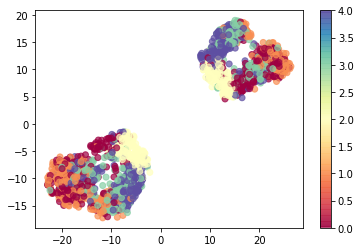

In [50]:
tsne = TSNE(n_components=2,perplexity=200)
Xred = tsne.fit_transform(audio_features_sorted)
plt.scatter(Xred[:,0], Xred[:,1], c=genres, cmap=plt.cm.Spectral, alpha=0.7)
plt.colorbar()

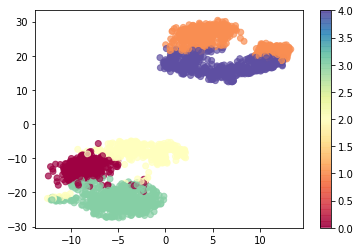

In [51]:
tsne = TSNE(n_components=2,perplexity=200)
Xred = tsne.fit_transform(audio_features_sorted)
plt.scatter(Xred[:,0], Xred[:,1], c=km_audio_features.labels_, cmap=plt.cm.Spectral, alpha=0.7)
plt.colorbar()

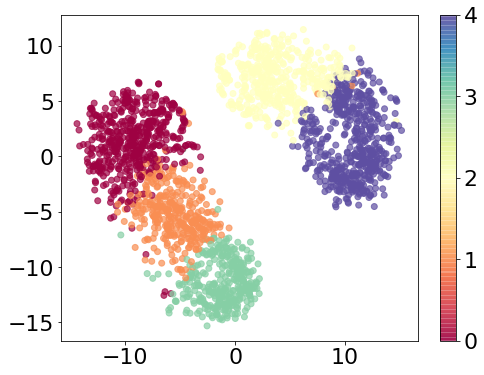

In [59]:
tsne = TSNE(n_components=2,perplexity=200)
Xred = tsne.fit_transform(audio_tracks_sorted)
plt.scatter(Xred[:,0], Xred[:,1], c=km_audio_tracks.labels_, cmap=plt.cm.Spectral, alpha=0.7)
plt.colorbar()

## UMAP

/home/frasco/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


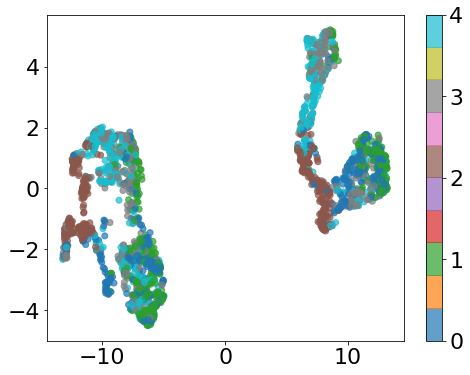

In [55]:
um = UMAP()
Xred = um.fit_transform(audio_features_sorted)
plt.scatter(Xred[:,0],Xred[:,1],c=genres,cmap=plt.cm.tab10,alpha=0.7)
plt.colorbar(ticks=range(6));

/home/frasco/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


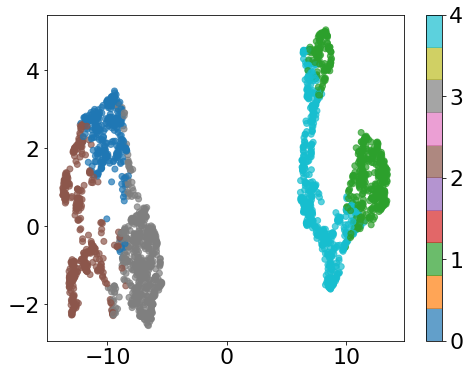

In [58]:
um = UMAP()
Xred = um.fit_transform(audio_features_sorted)
plt.scatter(Xred[:,0],Xred[:,1],c=km_audio_features.labels_,cmap=plt.cm.tab10,alpha=0.7)
plt.colorbar(ticks=range(6));

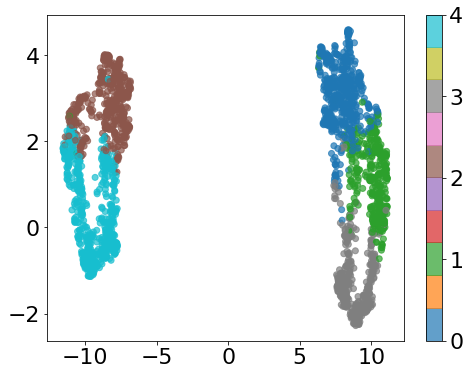

In [60]:
um = UMAP()
Xred = um.fit_transform(audio_tracks_sorted)
plt.scatter(Xred[:,0],Xred[:,1],c=km_audio_tracks.labels_,cmap=plt.cm.tab10,alpha=0.7)
plt.colorbar(ticks=range(6));